# Generate prediction by VARMA

In [1]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR,VARResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.tsa.stattools as st

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Show result of ADF inspection

In [2]:
def testStationarity(Frame):
	for ColumnsName in list(Frame):
		print("Name of variable:"+ ColumnsName)
		dftest = st.adfuller(Frame[ColumnsName])
		# describe result of adfuller function
		dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
		for key,value in dftest[4].items():
			dfoutput['Critical Value (%s)'%key] = value
		print(dfoutput)
		print("\n")

Import data and select 1,3,4 columns as predict data

In [3]:
df = pd.read_excel("AirQualityUCI.xlsx",parse_dates=[['Date', 'Time']])
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time
Frame = pd.DataFrame(data,columns=['CO(GT)','PT08.S1(CO)','C6H6(GT)'])

Using average of the numbers before and after to replace -200 (Vacancy value)

In [6]:
for row in list(Frame):
    for index,row_d in df.iterrows():
        if(Frame[row][index] == -200):
            m=1
            while(Frame[row][index+m] == -200):
                m+=1
            Frame[row][index] = (Frame[row][index-1]+Frame[row][index+m])/2

In [46]:
NewFrame = Frame.loc['2004-03-10 20:00:00':'2004-03-20 21:00:00']
Test_Frame = Frame.loc['2004-03-20 20:00:00':'2004-03-31 19:00:00']
testStationarity(NewFrame)

Name of variable:CO(GT)
Test Statistic                -7.043210e+00
p-value                        5.774920e-10
#Lags Used                     5.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


Name of variable:PT08.S1(CO)
Test Statistic                -6.126234e+00
p-value                        8.615766e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


Name of variable:C6H6(GT)
Test Statistic                -6.524673e+00
p-value                        1.021647e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critica

Autocorrelation test

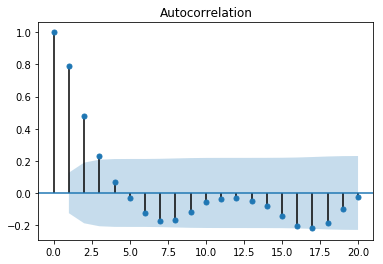

<Figure size 1296x432 with 0 Axes>

                     CO(GT)  PT08.S1(CO)   C6H6(GT)
Date_Time                                          
2004-03-10 20:00:00     2.2      1402.00   8.997817
2004-03-10 21:00:00     2.2      1375.50   9.228796
2004-03-10 22:00:00     1.6      1272.25   6.518224
2004-03-10 23:00:00     1.2      1197.00   4.741012
2004-03-11 00:00:00     1.2      1185.00   3.624399
...                     ...          ...        ...
2004-03-20 17:00:00     2.1      1392.25   9.724590
2004-03-20 18:00:00     2.3      1452.25  12.389162
2004-03-20 19:00:00     3.5      1633.00  16.644390
2004-03-20 20:00:00     3.9      1624.50  16.371624
2004-03-20 21:00:00     3.3      1534.50  13.735290

[242 rows x 3 columns]


In [8]:
plot_acf(NewFrame['C6H6(GT)'],lags=20)
plt.figure(figsize=(18, 6))
plt.show()
print(NewFrame)

Data here is stable but we still do first order difference, after this p-values turn to 0

In [18]:
first = NewFrame.loc['2004-03-10 21:00:00']#For Reduction sequence
diff_1_list = NewFrame.diff(1)
diff_1_list.dropna(inplace=True)
testStationarity(diff_1_list)

Name of variable:CO(GT)
Test Statistic                -7.779623e+00
p-value                        8.485740e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


Name of variable:PT08.S1(CO)
Test Statistic                -8.495425e+00
p-value                        1.279773e-13
#Lags Used                     8.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


Name of variable:C6H6(GT)
Test Statistic                -8.610544e+00
p-value                        6.493778e-14
#Lags Used                     7.000000e+00
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critica

#Code below used to determine the parameter p,q  
#arma_order_select_ic used here to give every variable's best p,q
#Result: 
#C6H6(GT)-> 'bic_min_order': (1, 2), 'aic_min_order': (4, 4), 'hqic_min_order': (4, 4)
#CO(GT)->'bic_min_order': (4, 4), 'aic_min_order': (4, 4), 'hqic_min_order': (4, 4)
#PT08.S1(CO)->'bic_min_order': (4, 3), 'aic_min_order': (4, 3), 'hqic_min_order': (4, 3)

In [19]:
# order = st.arma_order_select_ic(diff_1_list['PT08.S1(CO)'],max_ar = 5,max_ma = 4,ic = ['bic','aic','hqic'])

Generate prediction by VARMA

In [20]:
model = VARMAX(endog = diff_1_list, order=(4,4))
res = model.fit(maxiter=1000, disp=False)       

D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[sl

In [34]:
prediction = res.predict(strat = 0,end = 239)
#Due to the original sequence length is 240，end should be 239
#here if you want forecast future sequence,rmse can not be compute 

Compare the prediction and after first-order difference sequence

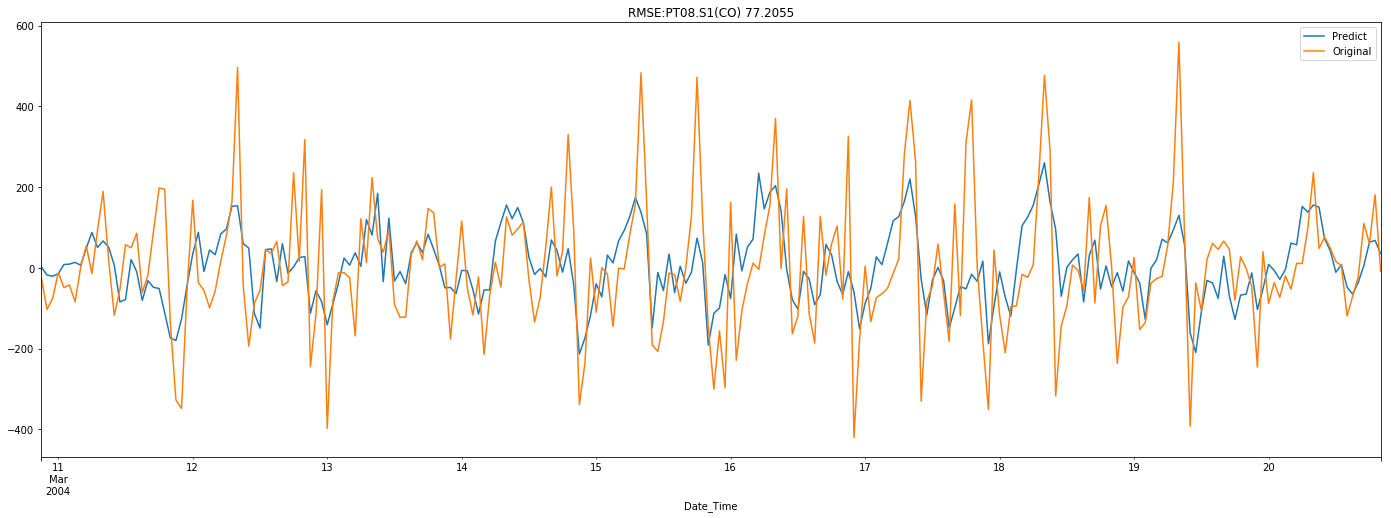

In [35]:
plt.figure(facecolor = 'white',figsize = (24,8))
prediction['PT08.S1(CO)'].plot(label='Predict')
diff_1_list['PT08.S1(CO)'].plot(label='Original')
plt.title('RMSE:PT08.S1(CO) %.4f'% np.sqrt(sum((diff_1_list['PT08.S1(CO)']-prediction['PT08.S1(CO)'])**2)/NewFrame.size))
plt.legend(loc='best')
plt.show()

Differential reduction 

In [36]:
print(diff_1_list,prediction)

                     CO(GT)  PT08.S1(CO)  C6H6(GT)
Date_Time                                         
2004-03-10 21:00:00     0.0       -26.50  0.230980
2004-03-10 22:00:00    -0.6      -103.25 -2.710573
2004-03-10 23:00:00    -0.4       -75.25 -1.777211
2004-03-11 00:00:00     0.0       -12.00 -1.116613
2004-03-11 01:00:00    -0.2       -48.75 -0.297722
...                     ...          ...       ...
2004-03-20 16:00:00    -0.1       -22.25 -0.920888
2004-03-20 17:00:00     0.5       109.75  3.010461
2004-03-20 18:00:00     0.2        60.00  2.664572
2004-03-20 19:00:00     1.2       180.75  4.255228
2004-03-20 20:00:00     0.4        -8.50 -0.272766

[240 rows x 3 columns]                        CO(GT)  PT08.S1(CO)  C6H6(GT)
2004-03-10 21:00:00  0.011783     1.779948  0.055009
2004-03-10 22:00:00 -0.115836   -18.073672 -0.696099
2004-03-10 23:00:00 -0.189709   -20.822929 -1.128450
2004-03-11 00:00:00 -0.088379   -14.706890 -0.729229
2004-03-11 01:00:00 -0.015365     8.151318  0.39

In [37]:
#prediction.shift(1)
prediction.loc['2004-03-10 21:00:00'] = first
x = 1
while(x<(prediction.shape[0])):
    prediction.iloc[x] = prediction.iloc[x-1]+prediction.iloc[x]
    x+=1

Plot result

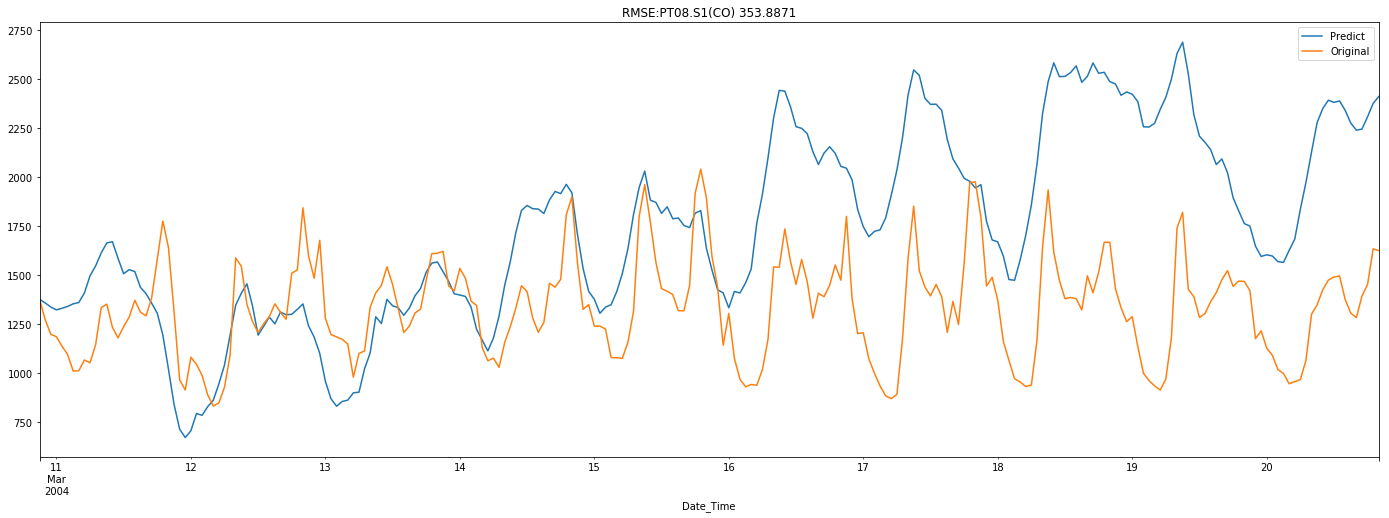

In [39]:
plt.figure(facecolor = 'white',figsize = (24,8))
prediction['PT08.S1(CO)'].plot(label='Predict')
NewFrame['PT08.S1(CO)'][1:].plot(label='Original')
plt.title('RMSE:PT08.S1(CO) %.4f'% np.sqrt(sum((prediction['PT08.S1(CO)']-NewFrame['PT08.S1(CO)'][1:])**2)/NewFrame.size))
plt.legend(loc='best')
plt.show()

Determine if the residual is white noise

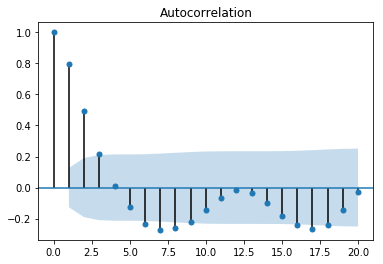

<Figure size 1296x432 with 0 Axes>

                     CO(GT)  PT08.S1(CO)   C6H6(GT)
Date_Time                                          
2004-03-10 21:00:00    -2.2     -1402.00  -8.997817
2004-03-10 22:00:00    -2.2     -1375.50  -9.228796
2004-03-10 23:00:00    -1.6     -1272.25  -6.518224
2004-03-11 00:00:00    -1.2     -1197.00  -4.741012
2004-03-11 01:00:00    -1.2     -1185.00  -3.624399
...                     ...          ...        ...
2004-03-20 16:00:00    -1.7     -1304.75  -7.635017
2004-03-20 17:00:00    -1.6     -1282.50  -6.714130
2004-03-20 18:00:00    -2.1     -1392.25  -9.724590
2004-03-20 19:00:00    -2.3     -1452.25 -12.389162
2004-03-20 20:00:00    -3.5     -1633.00 -16.644390

[240 rows x 3 columns]


In [27]:
Residual = diff_1_list - NewFrame[1:]
plot_acf(Residual['PT08.S1(CO)'],lags=20)
plt.figure(figsize=(18, 6))
plt.show()
print(Residual)

# Generate prediction by VAR

In [50]:
VAR_Model = VAR(endog=NewFrame)
lag_order = VAR_Model.select_order()
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        10.82       10.87   5.022e+04       10.84
1        8.322       8.503       4113.       8.395
2        8.029      8.346*       3070.      8.157*
3       8.009*       8.462      3010.*       8.192
4        8.011       8.599       3014.       8.248
5        8.043       8.767       3113.       8.335
6        8.043       8.903       3114.       8.390
7        8.084       9.080       3250.       8.486
8        8.075       9.206       3221.       8.531
9        8.098       9.365       3299.       8.609
10       8.119       9.522       3376.       8.685
11       8.072       9.611       3225.       8.693
12       8.047       9.722       3152.       8.723
13       8.028       9.839       3100.       8.759
14       8.043       9.990       3157.       8.829
15       8.067       10.15       3242.       8.907
-------------------------------

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [51]:
VAR_Prediction = VAR_Model.fit(3)
print(VAR_Prediction.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Jan, 2020
Time:                     16:30:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    8.33199
Nobs:                     239.000    HQIC:                   8.07146
Log likelihood:          -1930.90    FPE:                    2685.87
AIC:                      7.89561    Det(Omega_mle):         2375.09
--------------------------------------------------------------------
Results for equation CO(GT)
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.772872         0.749599            1.031           0.303
L1.CO(GT)             -0.352659         0.261000           -1.351           0.177
L1.PT08.S1(CO)         0.005780         0.001207       

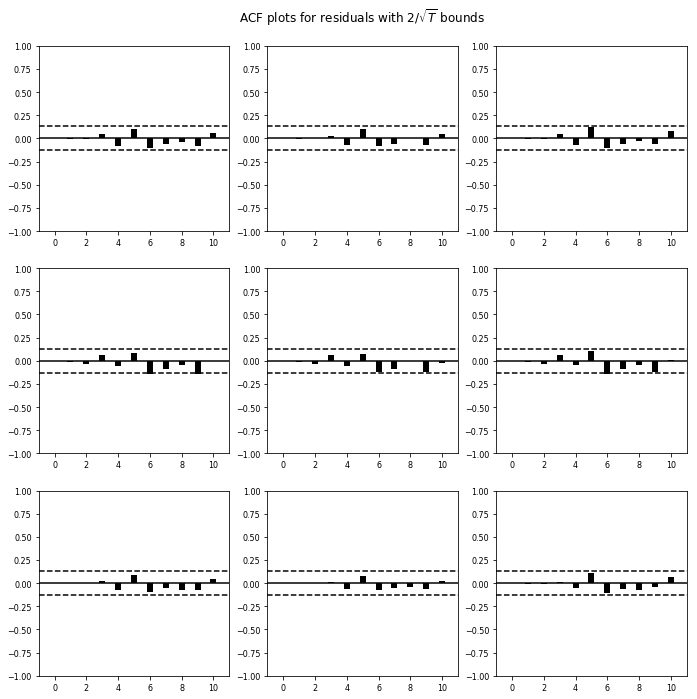

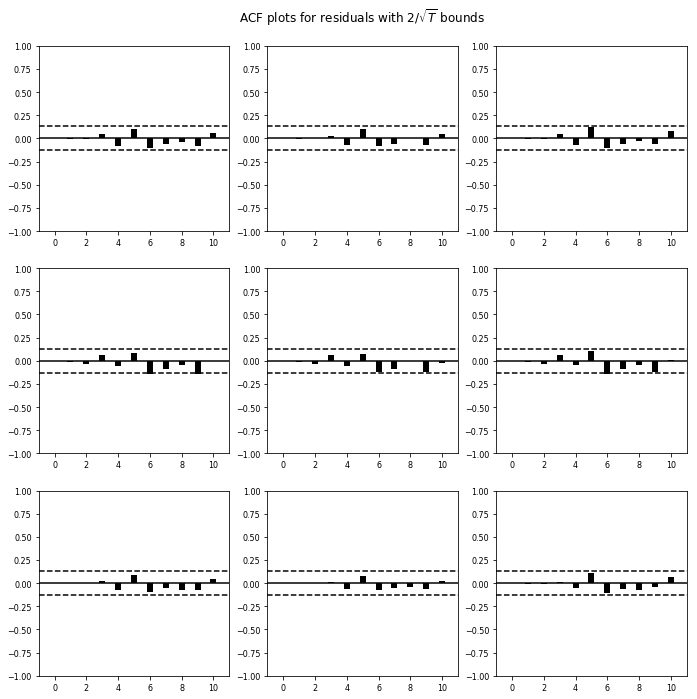

In [52]:
VAR_Prediction.plot_acorr(nlags=10, resid=True, linewidth=6)#滞后为10

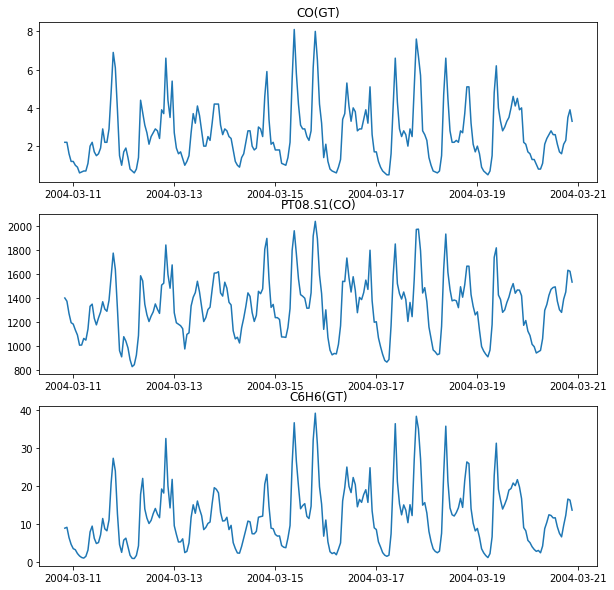

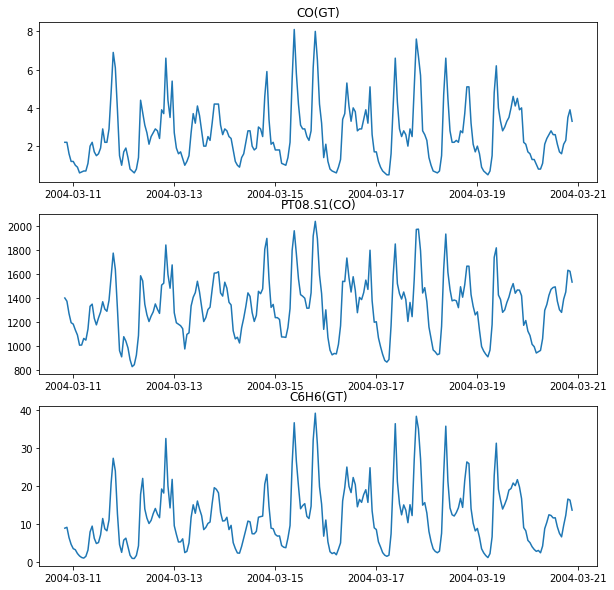

In [53]:
VAR_Prediction.plot()

In [54]:
lag_order = VAR_Prediction.k_ar
V_PRE = pd.DataFrame(VAR_Prediction.forecast(NewFrame.values[-lag_order:],240),columns=['CO(GT)','PT08.S1(CO)','C6H6(GT)'])
V_PRE.index = pd.date_range('2004-03-20 20:00:00',freq = 'h',periods= 240)

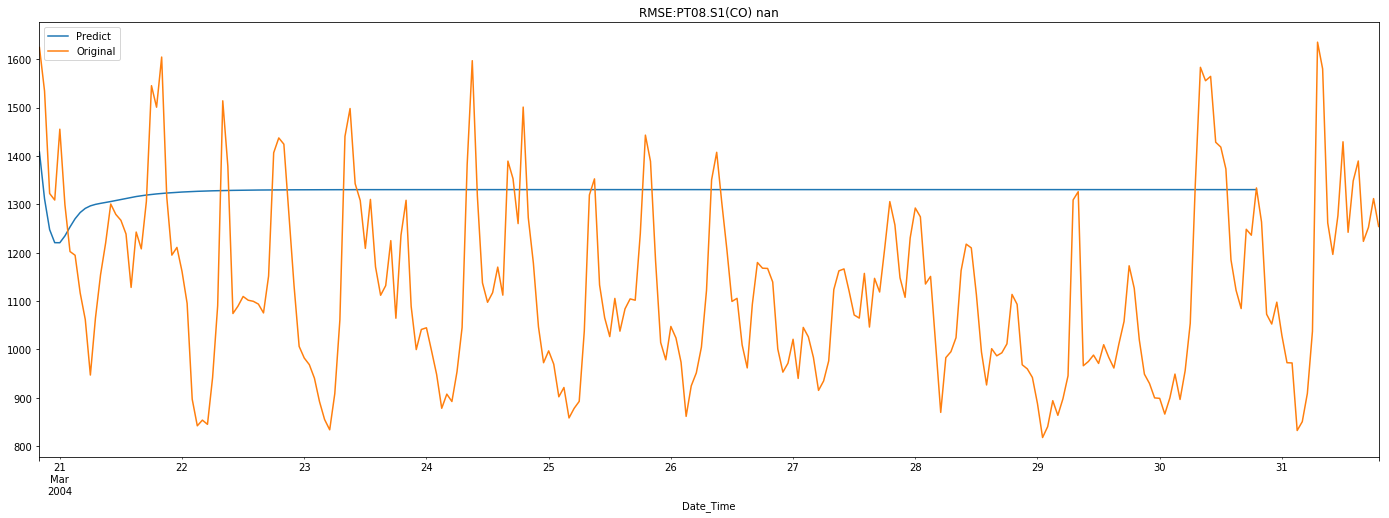

In [55]:
plt.figure(facecolor = 'white',figsize = (24,8))
V_PRE['PT08.S1(CO)'].plot(label='Predict')
Test_Frame['PT08.S1(CO)'].plot(label='Original')
plt.title('RMSE:PT08.S1(CO) %.4f'% np.sqrt(sum((V_PRE['PT08.S1(CO)']-Test_Frame['PT08.S1(CO)'])**2)/NewFrame.size))
plt.legend(loc='best')
plt.show()